In [1]:
# Forecasting future traffic on Wikipedia and drawing certain observations

In [2]:
# initial imports for reading training data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [3]:
# replacing NaN as I am concerned with the count of views and so it doesn't really matter whether it is NaN or 0.
train = pd.read_csv('../input/train_1.csv').fillna(0)

In [4]:
train.head()


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [5]:
# At first, I want to check whether traffic on Wikipedia is influenced by page language. 
# Its pretty basic since English is the most common language on internet.

def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'na'

train['lang'] = train.Page.map(get_language)

from collections import Counter

print(Counter(train.lang))

Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


In [6]:
# I am concerned with these 7 languages as these come from the countries where English reception is low, in my observation
lang_sets = {}
lang_sets['en'] = train[train.lang=='en'].iloc[:,0:-1]
lang_sets['ja'] = train[train.lang=='ja'].iloc[:,0:-1]
lang_sets['de'] = train[train.lang=='de'].iloc[:,0:-1]
lang_sets['na'] = train[train.lang=='na'].iloc[:,0:-1]
lang_sets['fr'] = train[train.lang=='fr'].iloc[:,0:-1]
lang_sets['zh'] = train[train.lang=='zh'].iloc[:,0:-1]
lang_sets['ru'] = train[train.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = train[train.lang=='es'].iloc[:,0:-1]

sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]


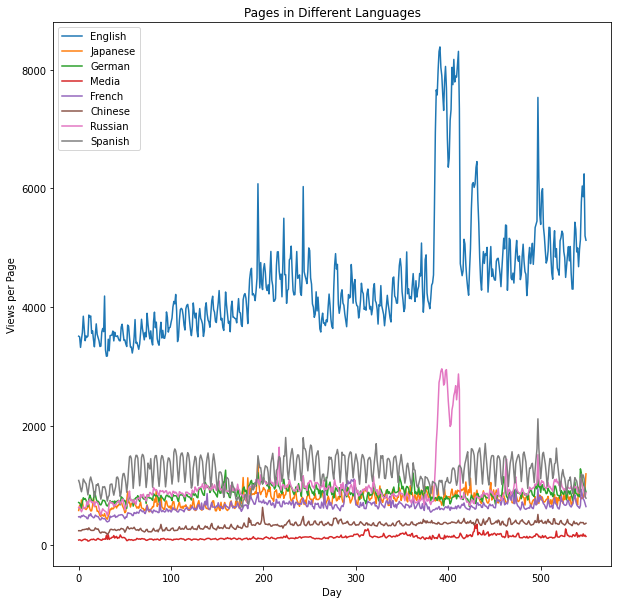

In [7]:
# I need to plot all languages v/s time in order to check whether any language stands out or something in terms of page views.
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1,figsize=[10,10])
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

for key in sums:
    plt.plot(days,sums[key],label = labels[key] )
    
plt.legend()
plt.show()

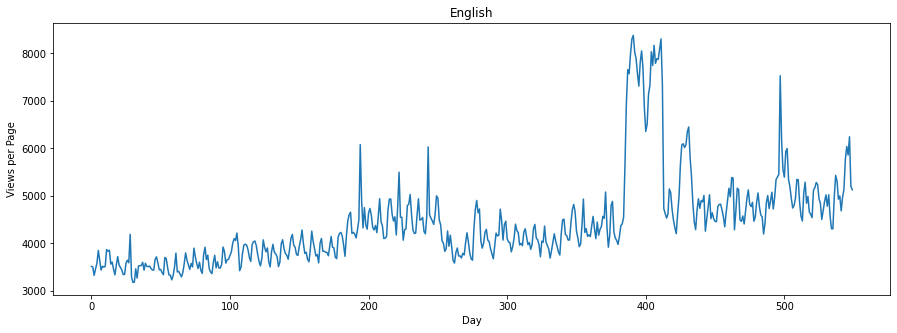

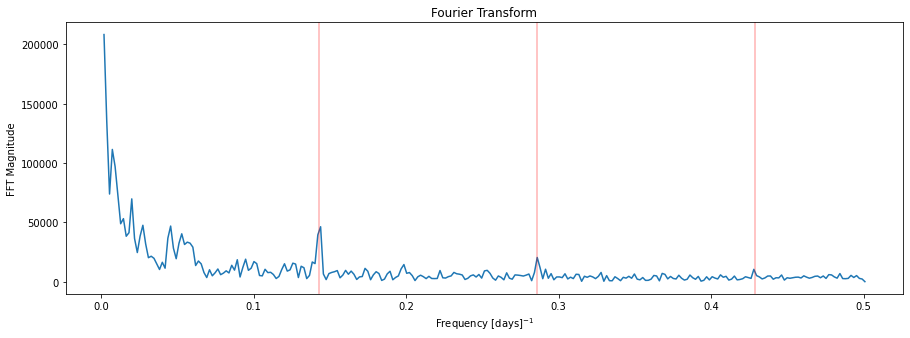

In [8]:
# as with almost all the time-series data, taking inferences from frequemcy is critical to predictions. 
# besides, I want to know about all the highs and lows of pages w.r.t time
# I AM DOING THIS TO DETECT WHETHER THERE EXISTS ANY PATTERN
# and theres no pattern as such but the closest pattern is observed for 0.14 days
# this means most of the sine waves distribution follow a freq of 0.14 days
from scipy.fftpack import fft
def plot_with_fft(key):

    fig = plt.figure(1,figsize=[15,5])
    plt.ylabel('Views per Page')
    plt.xlabel('Day')
    plt.title(labels[key])
    plt.plot(days,sums[key],label = labels[key] )
    
    fig = plt.figure(2,figsize=[15,5])
#     print(dir(sums[key]))
    
    fft_complex = fft(sums[key].values)
    fft_mag = [np.sqrt(np.real(x)*np.real(x)+np.imag(x)*np.imag(x)) for x in fft_complex]
    fft_xvals = [day / days[-1] for day in days]
    npts = len(fft_xvals) // 2 + 1
    fft_mag = fft_mag[:npts]
    fft_xvals = fft_xvals[:npts]
        
    plt.ylabel('FFT Magnitude')
    plt.xlabel(r"Frequency [days]$^{-1}$")
    plt.title('Fourier Transform')
    plt.plot(fft_xvals[1:],fft_mag[1:],label = labels[key] )
    # Draw lines at 1, 1/2, and 1/3 week periods
    plt.axvline(x=1./7,color='red',alpha=0.3)
    plt.axvline(x=2./7,color='red',alpha=0.3)
    plt.axvline(x=3./7,color='red',alpha=0.3)

    plt.show()

plot_with_fft('en')

In [9]:
# so, from all views, we drilled down to Enlgish, and now, I am going to check for particular pages.
def plot_entry(key,idx):
    data = lang_sets[key].iloc[idx,1:]
    fig = plt.figure(1,figsize=(10,5))
    plt.plot(days,data)
    plt.xlabel('day')
    plt.ylabel('views')
    plt.title(train.iloc[lang_sets[key].index[idx],0])
    
    plt.show()

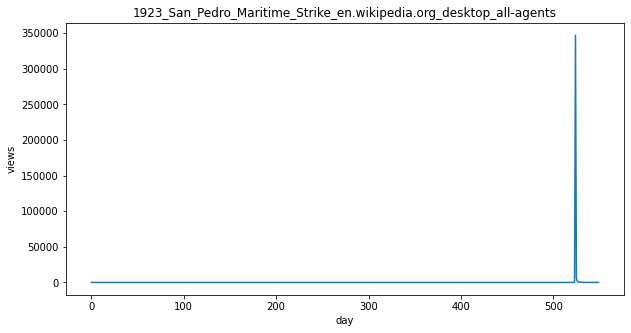

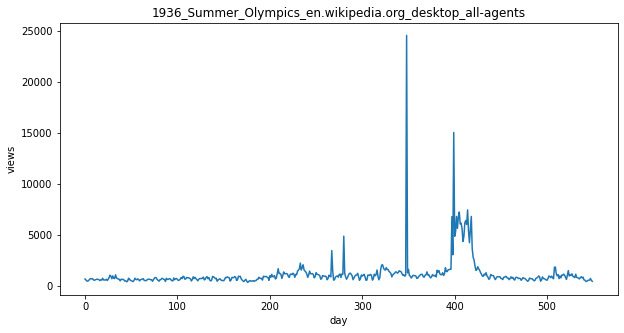

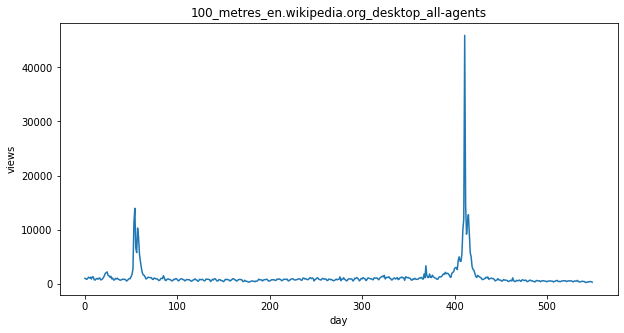

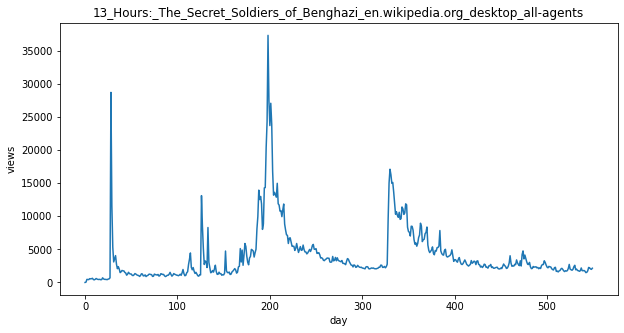

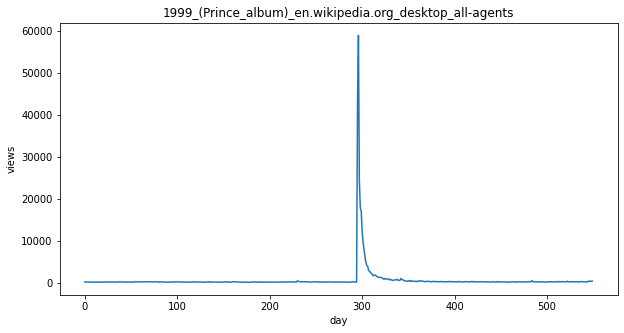

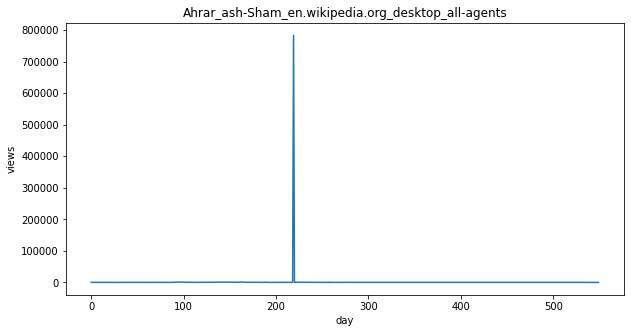

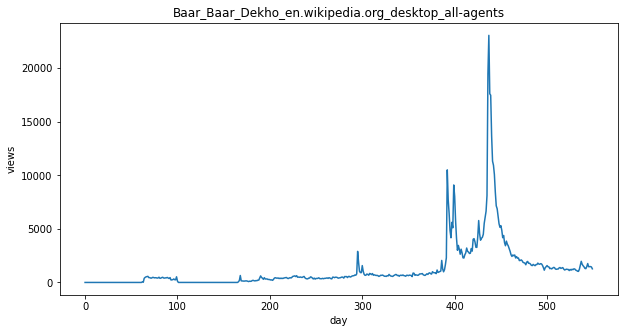

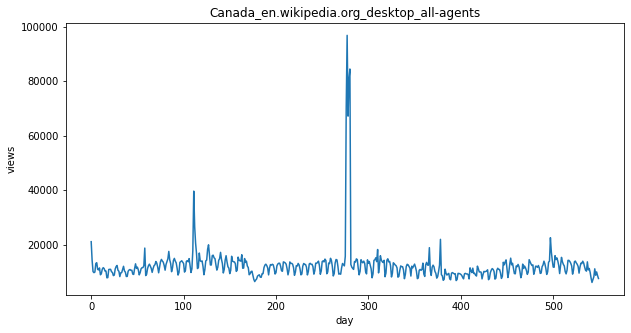

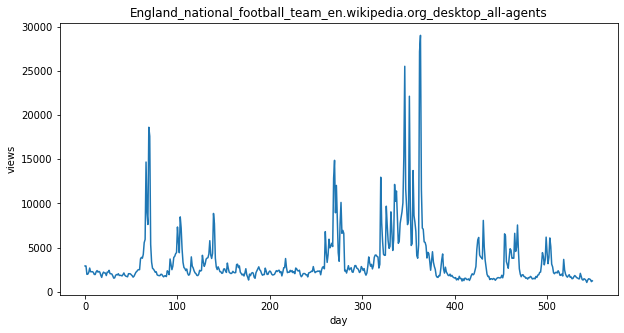

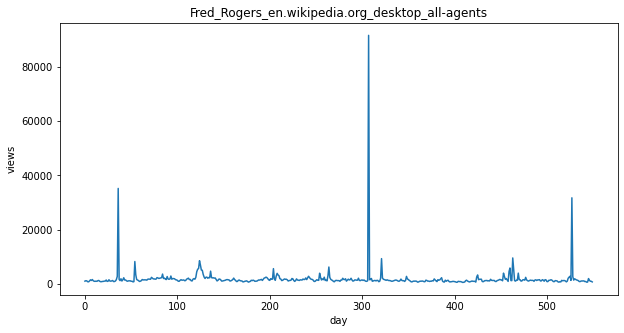

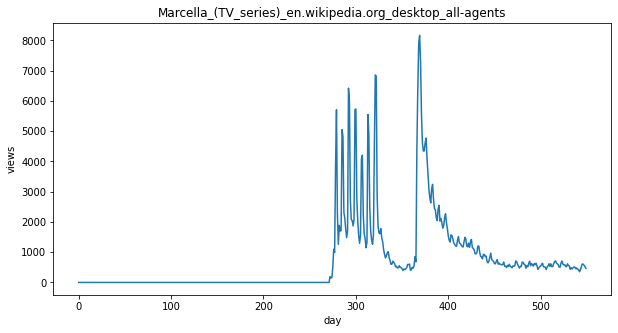

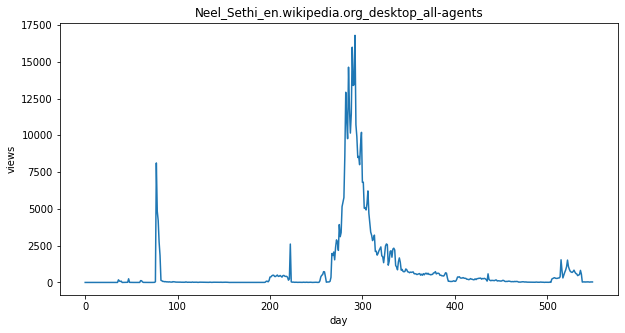

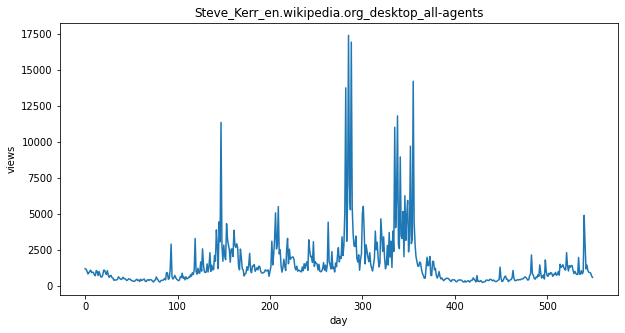

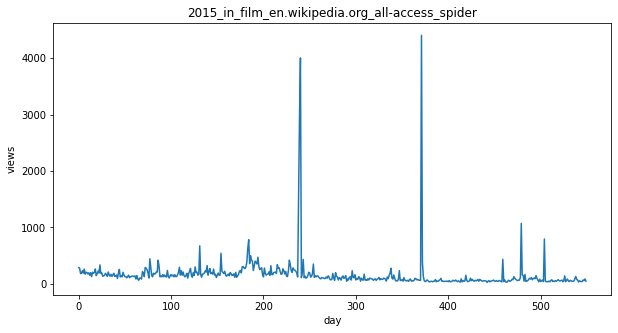

In [10]:
# just some random page numbers to get a decent plot and to check whether English lang matters or articles matter more
idx = [11, 12, 4, 7, 17, 117, 243, 393,687, 779,1431,3321,4701,5000]
for i in idx:
    plot_entry('en',i)

In [11]:
# For each language get top 10 (say) pages so that I know for sure that pages also matter and not just the language.
npages = 10
top_pages = {}
for key in ['en']:
    print(key)
    sum_set = pd.DataFrame(lang_sets[key][['Page']])
    sum_set['total'] = lang_sets[key].sum(axis=1)
    sum_set = sum_set.sort_values('total',ascending=False)
    print(sum_set.head(10))
    top_pages[key] = sum_set.index[0]
    print('\n\n')

en
                                                    Page         total
38573   Main_Page_en.wikipedia.org_all-access_all-agents  1.206618e+10
9774       Main_Page_en.wikipedia.org_desktop_all-agents  8.774497e+09
74114   Main_Page_en.wikipedia.org_mobile-web_all-agents  3.153985e+09
39180  Special:Search_en.wikipedia.org_all-access_all...  1.304079e+09
10403  Special:Search_en.wikipedia.org_desktop_all-ag...  1.011848e+09
74690  Special:Search_en.wikipedia.org_mobile-web_all...  2.921628e+08
39172  Special:Book_en.wikipedia.org_all-access_all-a...  1.339931e+08
10399   Special:Book_en.wikipedia.org_desktop_all-agents  1.332859e+08
33644       Main_Page_en.wikipedia.org_all-access_spider  1.290204e+08
34257  Special:Search_en.wikipedia.org_all-access_spider  1.243102e+08





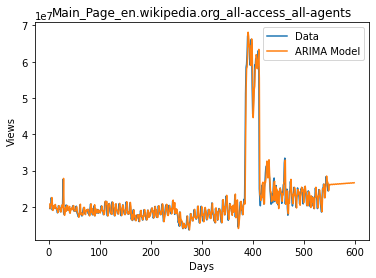

In [12]:
# topics in the news get a lot of views ( as seen in the first chart)
# so, this means that all the correlations can be dealt if i know that how does a page differ from its average
# but, what average should i chose as I dont want to make assumptions on the time frame?
# hence, moving average is always preferred when it comes to forecasting time series analysis
# as moving average takes care of the neighbourly changes, fundamentally

from statsmodels.tsa.arima_model import ARIMA
import warnings

cols = train.columns[1:-1]
for key in top_pages:
    data = np.array(train.loc[top_pages[key],cols],'f')
    result = None
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            arima = ARIMA(data,[2,1,4])
            result = arima.fit(disp=False)
        except:
            try:
                arima = ARIMA(data,[2,1,2])
                result = arima.fit(disp=False)
            except:
                print(train.loc[top_pages[key],'Page'])
                print('\tARIMA failed')
    #print(result.params)
    pred = result.predict(2,599,typ='levels')
    x = [i for i in range(600)]
    i=0

    plt.plot(x[2:len(data)],data[2:] ,label='Data')
    plt.plot(x[2:],pred,label='ARIMA Model')
    plt.title(train.loc[top_pages[key],'Page'])
    plt.xlabel('Days')
    plt.ylabel('Views')
    plt.legend()
    plt.show()


In [13]:
# yeah, the predictions from 400 to 430 do get a bit stuck
# but it seems overfitting as it copies almost everything
# a small pattern keeps on occuring and linear regression is applied.
# orange is a bit ahead of blue at almost every point.
# in simpler words, it is cramming the actual data.